In [8]:
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets, transforms

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
#добавим предварительную обработку фото и их нормализацию

In [4]:
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


100.0%
100.0%
100.0%
100.0%


выведем первые 10 фоток из датасеты с их метками

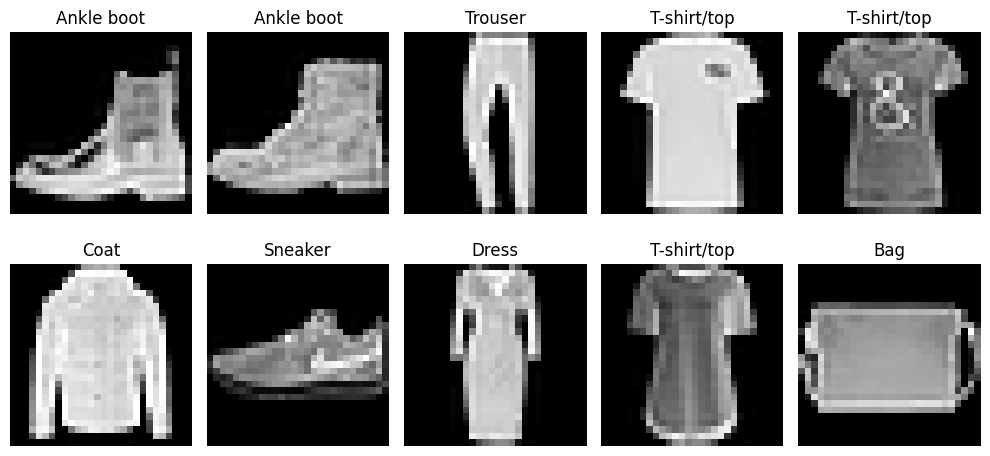

In [22]:
plt.figure(figsize=(10, 5))
for i in range(10):
    image, label = train_dataset[i]
    
    image = image.squeeze().numpy()
    image = (image * 0.5) + 0.5  
    
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

разделим датасет на тестовую и обучающую выборку

In [16]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True);
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False);

In [ ]:
создадим простую полносвязную сеть

In [7]:
model = nn.Sequential(
    nn.Flatten(),          
    nn.Linear(784, 128),  
    nn.ReLU(),
    nn.Linear(128, 10)     
)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [23]:
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 128]                  100,480
├─ReLU: 1-3                              [1, 128]                  --
├─Linear: 1-4                            [1, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

In [17]:
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

epochs = 15

for epoch in range(epochs):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss_value = train_running_loss / len(train_loader)
    train_accuracy_value = 100 * train_correct / train_total
    train_loss.append(train_loss_value)
    train_accuracy.append(train_accuracy_value)
    
    # Валидация
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss_value = val_running_loss / len(test_loader)
    val_accuracy_value = 100 * val_correct / val_total
    val_loss.append(val_loss_value)
    val_accuracy.append(val_accuracy_value)
    
    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss_value:.4f}, Train Acc: {train_accuracy_value:.2f}% | '
          f'Val Loss: {val_loss_value:.4f}, Val Acc: {val_accuracy_value:.2f}%')

Epoch 1/15: Train Loss: 0.2385, Train Acc: 91.20% | Val Loss: 0.2447, Val Acc: 90.95%
Epoch 2/15: Train Loss: 0.2290, Train Acc: 91.75% | Val Loss: 0.2618, Val Acc: 90.29%
Epoch 3/15: Train Loss: 0.2203, Train Acc: 91.81% | Val Loss: 0.2589, Val Acc: 90.43%
Epoch 4/15: Train Loss: 0.2126, Train Acc: 92.06% | Val Loss: 0.2700, Val Acc: 90.14%
Epoch 5/15: Train Loss: 0.2084, Train Acc: 92.13% | Val Loss: 0.2711, Val Acc: 89.93%
Epoch 6/15: Train Loss: 0.2018, Train Acc: 92.44% | Val Loss: 0.2827, Val Acc: 89.52%
Epoch 7/15: Train Loss: 0.1948, Train Acc: 92.71% | Val Loss: 0.2837, Val Acc: 89.70%
Epoch 8/15: Train Loss: 0.1917, Train Acc: 92.80% | Val Loss: 0.2658, Val Acc: 90.91%
Epoch 9/15: Train Loss: 0.1868, Train Acc: 93.05% | Val Loss: 0.2629, Val Acc: 90.44%
Epoch 10/15: Train Loss: 0.1796, Train Acc: 93.30% | Val Loss: 0.2709, Val Acc: 90.40%
Epoch 11/15: Train Loss: 0.1737, Train Acc: 93.53% | Val Loss: 0.2677, Val Acc: 90.52%
Epoch 12/15: Train Loss: 0.1720, Train Acc: 93.69% |

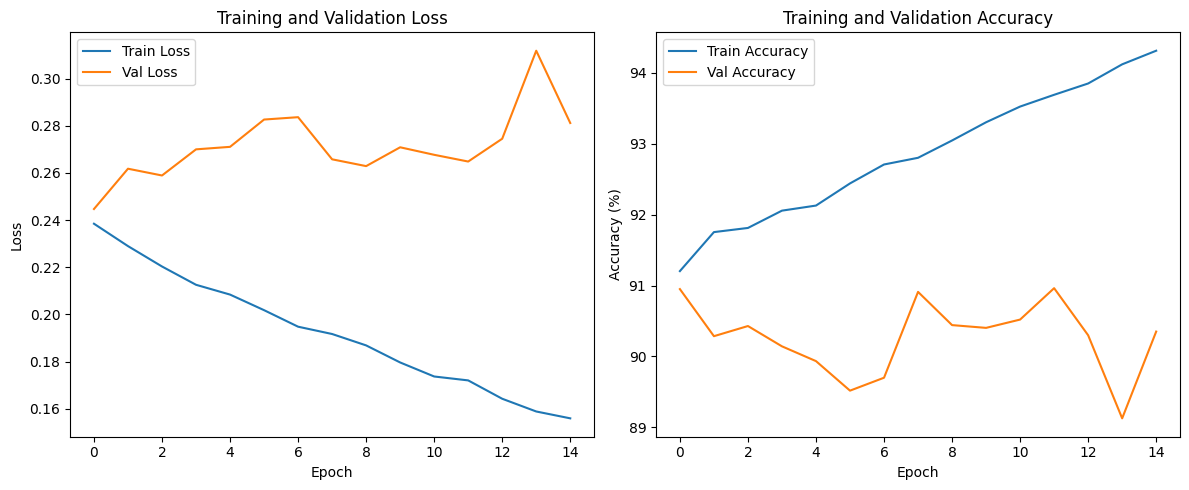

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

вывод: по графикам видно, что loss на валидационных данных растет а accuracy наоборот падает, и можно сделать вывод, что полносвязные сети не совсем хорошо подходят для работы с изображениями